# 3I026 - Intelligence artificielle & Data science

TP 4 : Programmation du kernel perceptron
=======

Dans ce TP, nous allons principalement étendre le perceptron du TP3 à l'aide de noyaux, avant de commencer le projet.

MENG_LINGSHU_3502972

Double-cliquer ici et remplacer par les noms et prénoms de votre binôme

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [192]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self, vector, label):
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x,vector))
            self.y = np.vstack((self.y,label))
        
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
        
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return self.x[i]
            
    #Renvoie la valeur de y_i
    def getY(self, i):
        return self.y[i]

In [193]:
class Classifier:
    def __init__(self, input_dimension):
        raise NotImplementedError("Please Implement this method")
    
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self, x):
        raise NotImplementedError("Please Implement this method")
    
    #Permet d'entrainer le modele sur un ensemble de données
    def train(self, labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    #Permet de calculer la qualité du système 
    def accuracy(self, dataset):
        nb_ok = 0
        for i in range(dataset.size()):
            output = self.predict(dataset.getX(i))
            if (output * dataset.getY(i) > 0):
                nb_ok = nb_ok + 1
        acc = nb_ok / (dataset.size() * 1.0)
        return acc

In [194]:
def generer_exemple(mean1=0, mean2=0):
    """Genere un exemple"""
    mean = [mean1, mean2]
    cov = [[1, 0], [0, 6]]
    return np.random.multivariate_normal(mean, cov)

def generer_exemples(nombre_exemples, mean1=0, mean2=0):
    """ Genere une liste de taille 'nombre_exemple' d'exemples """
    exemples = list()
    for _ in range(nombre_exemples):
        exemples.append(generer_exemple(mean1, mean2))   
    return exemples

def ajouter_exemples_aleatoires(the_set, nombre_exemples, mean1, mean2, labels):
    """ Ajoute dans 'the_set' un total de 'nombre_exemples' exemples
    associés aleatoirement à un label contenu dans 'labels'. """
    from random import choice
    exemples = generer_exemples(nombre_exemples, mean1, mean2)
    for exemple in exemples:
        the_set.addExample(exemple, choice(labels))

In [195]:
def plot_frontiere(set, classifier, step=20):
    mmax = set.x.max(0)
    mmin = set.x.min(0)
    x1grid, x2grid = np.meshgrid(np.linspace(mmin[0], mmax[0], step), np.linspace(mmin[1], mmax[1], step))
    grid = np.hstack((x1grid.reshape(x1grid.size, 1), x2grid.reshape(x2grid.size, 1)))
    
    # calcul de la prediction pour chaque point de la grille
    res = np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res = res.reshape(x1grid.shape)
    # tracé des frontieres
    plt.contourf(x1grid, x2grid, res, colors=["red", "cyan"], levels=[-1000,0,1000], linewidth=2)

In [196]:
def plot2DSet(dataset):
    plt.scatter(dataset.x[0:int(dataset.size()/2),0],dataset.x[0:int(dataset.size()/2),1],marker='o')
    plt.scatter(dataset.x[int(dataset.size()/2):dataset.size(),0],dataset.x[int(dataset.size()/2):dataset.size(),1],marker='x')


In [197]:
the_set = LabeledSet(3)

ajouter_exemples_aleatoires(the_set, 50, 0, 0, [1])
ajouter_exemples_aleatoires(the_set, 50, 1, 1, [1])
ajouter_exemples_aleatoires(the_set, 50, 1, 0, [-1])
ajouter_exemples_aleatoires(the_set, 50, 0, 1, [-1])

Kernel Trick
--------------

Nous allons projeter (manuellement) les données 2D dans un espace de plus grande dimension. Voici un exemple de projection qui transforme un vecteur $(x_1,x_2)$ en un vecteur $(x_1,x_2,1)$

In [198]:
class KernelBias:
    def transform(self, x):
        y=np.asarray([x[0],x[1],1])
        return y

k=KernelBias()
k.transform(the_set.getX(1))


array([-0.54769829,  3.46891119,  1.        ])

Implémentez la classe perceptron qui prend un Kernel en paramètre, et calcule le perceptron sur la version "kernélisée" des données. Tester ce perceptron sur le dataset 1 (2 gaussiennes) et le dataset XOR

In [199]:
class PerceptronKernel(Classifier):
    
    def __init__(self, dimension_kernel, learning_rate, nombre_iterations, kernel):
        
        self.dimension_kernel = dimension_kernel
        self.learning_rate = learning_rate
        self.nombre_iterations = nombre_iterations
        self.kernel = kernel
        self.w = np.random.rand(self.dimension_kernel)
    
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x): 
        
        z = np.dot(self.kernel.transform(x), self.w)
        if z > 0:
            return +1
        else:
            return -1

    
    #Permet d'entrainer le modele sur un ensemble de données
    def train(self,labeledSet):
        
        for p in range(self.nombre_iterations):
            for i in range(labeledSet.size()):  
                if (self.predict(labeledSet.getX(i)) * labeledSet.getY(i)) < 0:
                    self.w = self.w + self.learning_rate * labeledSet.getY(i) * self.kernel.transform(labeledSet.getX(i))
                    

0.365


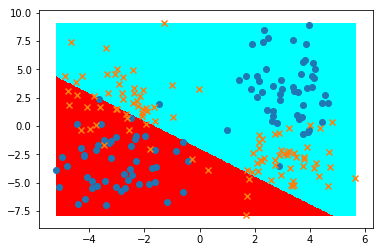

In [200]:
N=100
k=KernelBias()
k.transform(the_set.getX(1))
perceptron_k = PerceptronKernel(3, 0.0001, 10, k)
### TODO: Tester le perceptron sur les deux datasets

#dataset de l'apprentissage
set_apprentissage = LabeledSet(3)
ajouter_exemples_aleatoires(set_apprentissage, 50, 0, 0, [1])
ajouter_exemples_aleatoires(set_apprentissage, 50, 1, 1, [1])
ajouter_exemples_aleatoires(set_apprentissage, 50, 1, 0, [-1])
ajouter_exemples_aleatoires(set_apprentissage, 50, 0, 1, [-1])

#dataset de test
set_test = LabeledSet(3)
ajouter_exemples_aleatoires(set_test, 50, 3, 3, [1])
ajouter_exemples_aleatoires(set_test, 50, -3, -3, [1])
ajouter_exemples_aleatoires(set_test, 50, 3, -3, [-1])
ajouter_exemples_aleatoires(set_test, 50, -3, 3, [-1])

perceptron_k.train(set_apprentissage)
plot_frontiere(set_test, perceptron_k, 200)
print(perceptron_k.accuracy(set_test))
plot_frontiere(set_test,perceptron_k,200)
plot2DSet(set_test)

Implémenter le kernel : $(x_1,x_2) \rightarrow (1,x_1,x_2,x_1*x_1,x_2*x_2,x_1*x_2)$. Entrainez le perceptron correspondant sur le XOR. Que constatez vous ? Donnez une explication.

In [201]:
#prof
class KernelPoly:
    def transform(self, x):
        '''array = []
        for i in range(3):
            array.append(x[i])
            array.append(pow(x[i], 2))
        y=np.asarray([array, 1])'''
        y=np.asarray([x[0], x[1], x[0]*x[1], pow(x[0],2), pow(x[1], 2), 1])
        return y

0.835


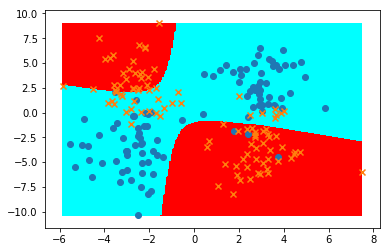

In [202]:
N=100
k = KernelPoly()
k.transform(the_set.getX(1))
perceptron_k = PerceptronKernel(6, 0.0001, 10, k)

### TODO: Tester le perceptron sur les deux datasets

#dataset de l'apprentissage
set_apprentissage = LabeledSet(3)
ajouter_exemples_aleatoires(set_apprentissage, 50, 0, 0, [1])
ajouter_exemples_aleatoires(set_apprentissage, 50, 1, 1, [1])
ajouter_exemples_aleatoires(set_apprentissage, 50, 1, 0, [-1])
ajouter_exemples_aleatoires(set_apprentissage, 50, 0, 1, [-1])

#dataset de test
set_test = LabeledSet(3)
ajouter_exemples_aleatoires(set_test, 50, 3, 3, [1])
ajouter_exemples_aleatoires(set_test, 50, -3, -3, [1])
ajouter_exemples_aleatoires(set_test, 50, 3, -3, [-1])
ajouter_exemples_aleatoires(set_test, 50, -3, 3, [-1])

perceptron_k.train(set_apprentissage)
plot_frontiere(set_test, perceptron_k, 200)
print(perceptron_k.accuracy(set_test))
plot_frontiere(set_test,perceptron_k, 200)
plot2DSet(set_test)

Mise en oeuvre sur des données réelles 
-------
Tester la version à noyau du perceptron sur les données réelles

In [203]:
from sklearn.datasets import fetch_mldata

def loadFile(name):
    data = fetch_mldata(name, data_home = '/Users/Lingshu/Desktop/3I026/TME4/')
    print(data.data.shape)
    unique = np.unique(data.target)
    for i in range(len(data.target)):
        if (data.target[i]==unique[0]):
            data.target[i]=1
        else:
            data.target[i]=-1
    return data.data, data.target
datas,targets = loadFile('breast-cancer_scale')
print(datas)
#print(targets) #les labels
#Les donnees sont dans data.data et data.target

(683, 10)
[[-0.860107 -0.111111 -1.       ..., -0.555556 -1.       -1.      ]
 [-0.859671 -0.111111 -0.333333 ..., -0.555556 -0.777778 -1.      ]
 [-0.857807 -0.555556 -1.       ..., -0.555556 -1.       -1.      ]
 ..., 
 [-0.876716 -0.111111  1.       ...,  0.555556  1.       -0.777778]
 [-0.875424 -0.333333  0.555556 ...,  1.        0.111111 -1.      ]
 [-0.875424 -0.333333  0.555556 ...,  1.       -0.333333 -1.      ]]


In [204]:
def split(data):
    data_apprentissage = data[:int(len(data)/2)]
    data_test = data[int(len(data)/2):]
    return data_apprentissage, data_test
data_apprentissage, data_test = split(datas)
labels_apprentissage, labels_test = split(targets)
#on verifie si on reussit a separer les datas et les targets 
#print(len(data_apprentissage))
#print(len(data_test))
#print(len(datas))'''

In [205]:
def turn_to_LabeledSet(tab1,tab2):
    set_appretissage = LabeledSet(len(tab1))
    for i in range(len(tab1)):
        set_appretissage.addExample(tab1[i], tab2[i])
    return set_apprentissage
                   
set_apprentissage_real = turn_to_LabeledSet(data_apprentissage,labels_apprentissage)
set_test_real = turn_to_LabeledSet(data_test,labels_test)

N=100
k = KernelPoly()
k.transform(the_set.getX(1))
perceptron_k = PerceptronKernel(10, 0.0001, 10, k)

perceptron_real = PerceptronKernel(set_apprentissage_real.getInputDimension(), 0.0001, 10, k)
perceptron_real.train(set_apprentissage_real)
plot_frontiere(set_test_real, perceptron_real, 200)
print(perceptron.accuracy(set_test_real))
plot_frontiere(set_test_real, perceptron_real, 200)
plot2DSet(set_test_real) 

ValueError: shapes (6,) and (3,) not aligned: 6 (dim 0) != 3 (dim 0)